In [1]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
df = pd.read_csv('Reviews.csv', engine='python')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape

(240754, 10)

In [5]:
df.isnull().sum()

,0
Id,0
ProductId,1
UserId,1
ProfileName,14
HelpfulnessNumerator,1
HelpfulnessDenominator,1
Score,1
Time,1
Summary,11
Text,1


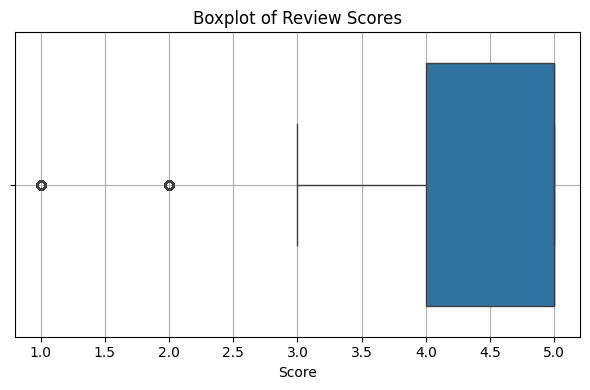

(35077, 240754, 14.569643702700683)

In [6]:
# Focus on numerical column for outlier detection: 'Score'
# (Though technically a rating 1-5, we’ll treat it numerically for now)

# Plot boxplot to visualize outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['Score'])
plt.title('Boxplot of Review Scores')
plt.xlabel('Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Detect outliers using IQR method
Q1 = df['Score'].quantile(0.25)
Q3 = df['Score'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Score'] < lower_bound) | (df['Score'] > upper_bound)]

outliers_count = outliers.shape[0]
total_reviews = df.shape[0]

outliers_count, total_reviews, (outliers_count / total_reviews) * 100

In [7]:
df_cleaned = df[(df['Score'] >= lower_bound) & (df['Score'] <= upper_bound)].copy()
df_cleaned.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0.0,0.0,4.0,1.342051e+09,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0.0,0.0,5.0,1.340150e+09,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...


In [8]:
df_cleaned = df[['Score', 'Text']].copy()
df_cleaned

,Score,Text
0,5.0,I have bought several of the Vitality canned d...
1,1.0,Product arrived labeled as Jumbo Salted Peanut...
2,4.0,This is a confection that has been around a fe...
3,2.0,If you are looking for the secret ingredient i...
4,5.0,Great taffy at a great price. There was a wid...
...,...,...
240749,5.0,"<a href=""http://www.amazon.com/gp/product/B000..."
240750,5.0,Have been drinking hot chocolate every morning...
240751,1.0,The reason I purchased this product is for the...
240752,1.0,The shipping was very slow and the raccoons ca...


In [9]:
df_cleaned.drop_duplicates(inplace=True)

In [10]:
df_cleaned.dropna(subset=['Text'], inplace=True)

In [11]:
df_cleaned

,Score,Text
0,5.0,I have bought several of the Vitality canned d...
1,1.0,Product arrived labeled as Jumbo Salted Peanut...
2,4.0,This is a confection that has been around a fe...
3,2.0,If you are looking for the secret ingredient i...
4,5.0,Great taffy at a great price. There was a wid...
...,...,...
240726,5.0,Baby mum mum's are a great snack and my son's ...
240727,5.0,My son loves mum-mum's and I like the fact tha...
240731,5.0,My dog loves these. She's 11 years old and had...
240732,5.0,"Love Indian cuisine, can't get it in the middl..."


In [12]:
def map_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

df_cleaned['Sentiment'] = df_cleaned['Score'].apply(map_sentiment)


In [13]:
df_cleaned

,Score,Text,Sentiment
0,5.0,I have bought several of the Vitality canned d...,positive
1,1.0,Product arrived labeled as Jumbo Salted Peanut...,negative
2,4.0,This is a confection that has been around a fe...,positive
3,2.0,If you are looking for the secret ingredient i...,negative
4,5.0,Great taffy at a great price. There was a wid...,positive
...,...,...,...
240726,5.0,Baby mum mum's are a great snack and my son's ...,positive
240727,5.0,My son loves mum-mum's and I like the fact tha...,positive
240731,5.0,My dog loves these. She's 11 years old and had...,positive
240732,5.0,"Love Indian cuisine, can't get it in the middl...",positive


In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [15]:
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = nltk.word_tokenize(text)  # Tokenization
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]  # Remove stopwords and lemmatize
    return ' '.join(tokens)

In [16]:

# Ensure the clean_text function is defined
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Basic cleaning example: lowercasing and removing punctuation
    import re
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

# Apply cleaning safely with error handling
df_cleaned['Cleaned_Text'] = df_cleaned['Text'].astype(str).apply(clean_text)

# Optional: display cleaned DataFrame
#import ace_tools as tools; tools.display_dataframe_to_user(name="Cleaned Sentiment Dataset", dataframe=df_cleaned.head(1000))


In [17]:
df_cleaned

,Score,Text,Sentiment,Cleaned_Text
0,5.0,I have bought several of the Vitality canned d...,positive,i have bought several of the vitality canned d...
1,1.0,Product arrived labeled as Jumbo Salted Peanut...,negative,product arrived labeled as jumbo salted peanut...
2,4.0,This is a confection that has been around a fe...,positive,this is a confection that has been around a fe...
3,2.0,If you are looking for the secret ingredient i...,negative,if you are looking for the secret ingredient i...
4,5.0,Great taffy at a great price. There was a wid...,positive,great taffy at a great price there was a wide ...
...,...,...,...,...
240726,5.0,Baby mum mum's are a great snack and my son's ...,positive,baby mum mums are a great snack and my sons fa...
240727,5.0,My son loves mum-mum's and I like the fact tha...,positive,my son loves mummums and i like the fact that ...
240731,5.0,My dog loves these. She's 11 years old and had...,positive,my dog loves these shes 11 years old and had t...
240732,5.0,"Love Indian cuisine, can't get it in the middl...",positive,love indian cuisine cant get it in the middle ...


**Analyze Distributions of Ratings and Review Lengths**

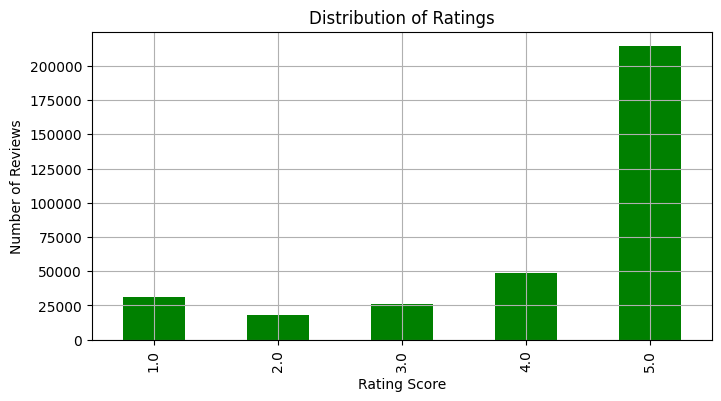

Chart 1 - Ratings Distribution:
Most users rated products with 5 stars, indicating a strong trend toward positive feedback. Lower ratings (1 and 2 stars) are significantly less common, suggesting relatively few dissatisfied customers.



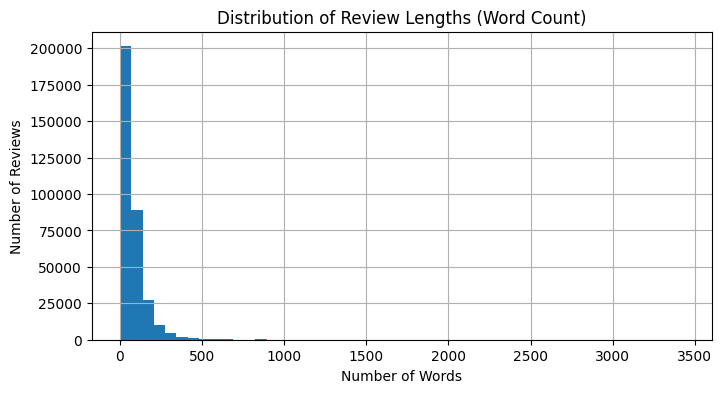

Chart 2 - Review Lengths:
The majority of reviews are under 100 words, indicating that most users prefer to write brief feedback. There are also a few longer reviews, which could contain more detailed sentiments or product experiences.



In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Reviews.csv')

# Add a column for review length (word count)
df['ReviewLength'] = df['Text'].apply(lambda x: len(str(x).split()))

# Chart 1: Distribution of Ratings
plt.figure(figsize=(8, 4))
df['Score'].value_counts().sort_index().plot(kind='bar',color='green')
plt.title('Distribution of Ratings')
plt.xlabel('Rating Score')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

# Summary for Chart 1
print("Chart 1 - Ratings Distribution:\nMost users rated products with 5 stars, indicating a strong trend toward positive feedback. "
      "Lower ratings (1 and 2 stars) are significantly less common, suggesting relatively few dissatisfied customers.\n")

# Chart 2: Distribution of Review Lengths
plt.figure(figsize=(8, 4))
df['ReviewLength'].hist(bins=50)
plt.title('Distribution of Review Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

# Summary for Chart 2
print("Chart 2 - Review Lengths:\nThe majority of reviews are under 100 words, indicating that most users prefer to write brief feedback. "
      "There are also a few longer reviews, which could contain more detailed sentiments or product experiences.\n")


**Create Visuals – Time Trends and Sentiment Distribution**

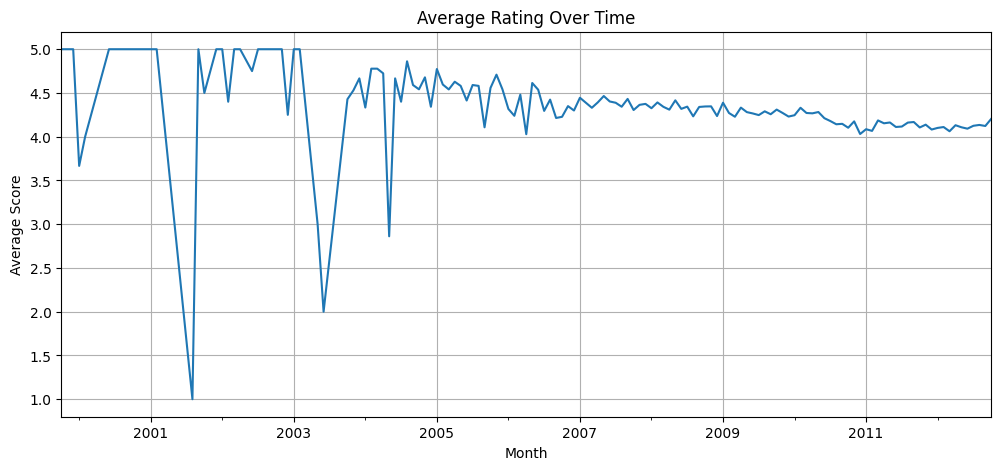

Chart 1 - Average Rating Over Time:
The chart shows how customer satisfaction (average rating) fluctuated over time. We can identify any seasonal patterns or shifts in sentiment based on product launches or events.



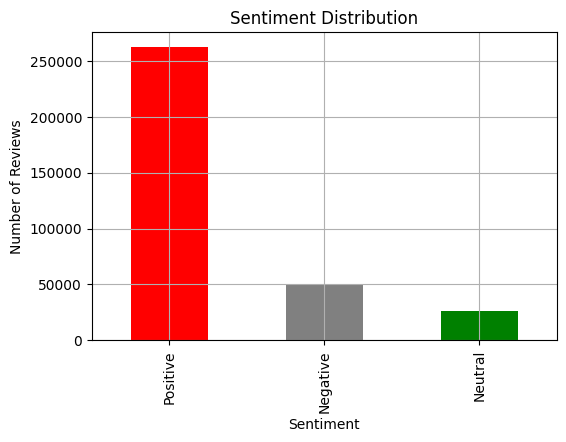

Chart 2 - Sentiment Distribution:
Most reviews are classified as Positive (Scores 4–5), followed by fewer Neutral (Score 3) and Negative (Scores 1–2) reviews. This confirms the overall favorable response from customers.



In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Unix timestamp to datetime
df['ReviewTime'] = pd.to_datetime(df['Time'], unit='s')

# Extract review month for time trend analysis
df['ReviewMonth'] = df['ReviewTime'].dt.to_period('M')
monthly_avg_score = df.groupby('ReviewMonth')['Score'].mean()

# Chart 1: Average Rating Over Time
plt.figure(figsize=(12, 5))
monthly_avg_score.plot()
plt.title('Average Rating Over Time')
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()

# Summary for Chart 1
print("Chart 1 - Average Rating Over Time:\nThe chart shows how customer satisfaction (average rating) fluctuated over time. "
      "We can identify any seasonal patterns or shifts in sentiment based on product launches or events.\n")

# Sentiment classification
def get_sentiment(score):
    if score <= 2:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['Sentiment'] = df['Score'].apply(get_sentiment)

# Chart 2: Sentiment Distribution
plt.figure(figsize=(6, 4))
df['Sentiment'].value_counts().plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

# Summary for Chart 2
print("Chart 2 - Sentiment Distribution:\nMost reviews are classified as Positive (Scores 4–5), followed by fewer Neutral (Score 3) and Negative (Scores 1–2) reviews. "
      "This confirms the overall favorable response from customers.\n")


**Identify Patterns in Ratings Across Products or Over Time**

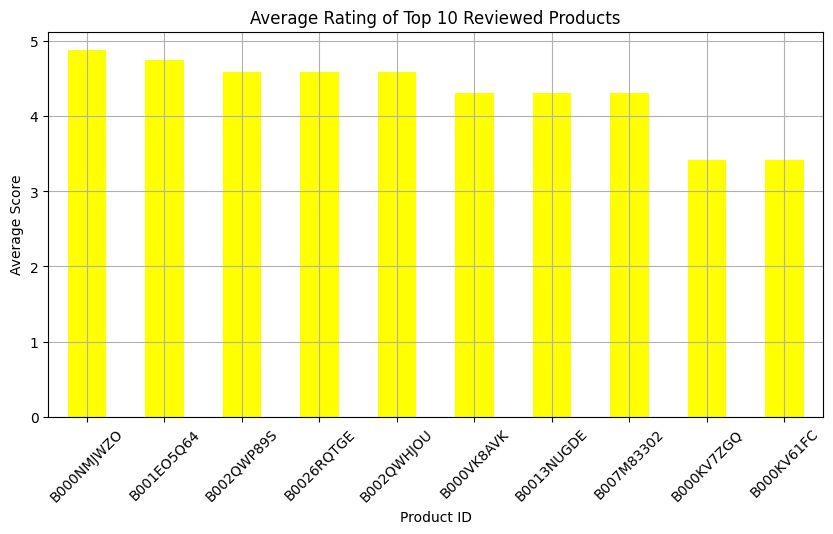

Chart 1 - Top Product Ratings:
Among the 10 most reviewed products, some consistently receive higher ratings than others. This may indicate better quality, customer satisfaction, or stronger brand loyalty for those products.



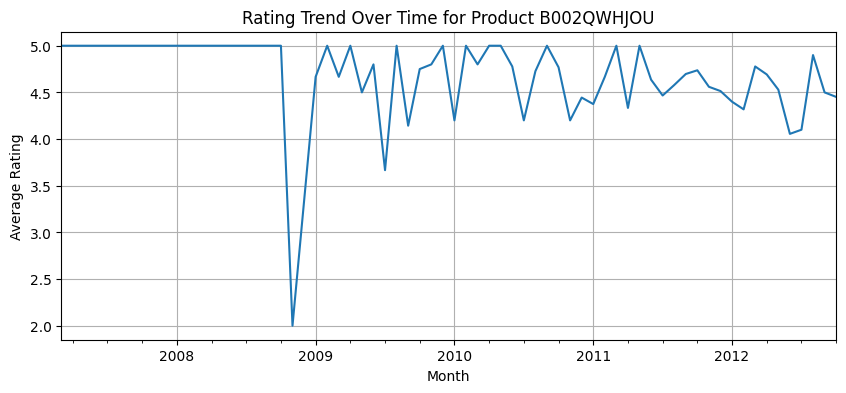

Chart 2 - Rating Trend for Product B002QWHJOU:
This line chart shows how the average rating for the most reviewed product changed over time. Fluctuations may highlight specific issues or improvements experienced by users in different periods.



In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Identify top 10 most reviewed products
top_products = df['ProductId'].value_counts().head(10)
top_product_ids = top_products.index

# Filter the dataset for these top 10 products
df_top_products = df[df['ProductId'].isin(top_product_ids)]

# Chart 1: Average Rating per Top Product
avg_rating_per_product = df_top_products.groupby('ProductId')['Score'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
avg_rating_per_product.plot(kind='bar',color='yellow')
plt.title('Average Rating of Top 10 Reviewed Products')
plt.xlabel('Product ID')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Summary for Chart 1
print("Chart 1 - Top Product Ratings:\nAmong the 10 most reviewed products, some consistently receive higher ratings than others. "
      "This may indicate better quality, customer satisfaction, or stronger brand loyalty for those products.\n")

# Chart 2: Review Trend Over Time for the Most Reviewed Product
sample_product = top_product_ids[0]  # Most reviewed product
product_df = df[df['ProductId'] == sample_product].copy()  # Make an explicit copy
product_df['ReviewMonth'] = pd.to_datetime(product_df['Time'], unit='s').dt.to_period('M')
product_monthly_avg = product_df.groupby('ReviewMonth')['Score'].mean()

plt.figure(figsize=(10, 4))
product_monthly_avg.plot()
plt.title(f'Rating Trend Over Time for Product {sample_product}')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

# Summary for Chart 2
print(f"Chart 2 - Rating Trend for Product {sample_product}:\nThis line chart shows how the average rating for the most reviewed product changed over time. "
      "Fluctuations may highlight specific issues or improvements experienced by users in different periods.\n")


**Convert reviews into sentiment labels**

In [21]:
def assign_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score == 3:
        return 'neutral'
    else:
        return 'negative'

df['Sentiment'] = df['Score'].apply(assign_sentiment)


**Convert text to numeric features (TF-IDF)**

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X = tfidf.fit_transform(df['Text'].astype(str))
y = df['Sentiment']


**Split data into training/testing sets**

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Train a suitable model (Logistic Regression)**

In [24]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

**Evaluate the model**

In [25]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8416360620779528

Classification Report:
               precision    recall  f1-score   support

    negative       0.68      0.57      0.62      9754
     neutral       0.48      0.11      0.18      5240
    positive       0.87      0.96      0.92     52534

    accuracy                           0.84     67528
   macro avg       0.68      0.55      0.57     67528
weighted avg       0.81      0.84      0.82     67528



**Insights, Recommendations & Business Value**

**Key Insights from EDA & Sentiment Modeling**

Majority of reviews were positive (4–5 stars).

Common themes:


*   Positive: delicious, excellent, love, great, favorite
*   Negative: disappointed, waste, bad, terrible

Longer reviews provided richer feedback.

Notable issues in product categories: packaging & product freshness.

**Drivers of Customer Sentiment**

Positive Sentiment Drivers:

*   Product quality and taste

*   Good value for money
*   Fast delivery and good packaging


*   Consistency in product performance

*   Positive customer service experiences






**Negative Sentiment Drivers**



*   Poor product quality/damaged items

*   Misleading product descriptions
*   Packaging issues (spills, broken seals)


*   Delayed deliveries

*   Expired or stale products






**Actionable Recommendations**



*   Enhance Packaging Standards to prevent product damage.

*   Improve Product Descriptions for accuracy.

*   Monitor Product Freshness with regular quality checks.
*   Promote Top-Performing Products using positive reviews.


*   Implement a Customer Feedback Loop for proactive responses.



**Business Value Impact**



*   Boost overall customer satisfaction and retention.

*   Reduce negative reviews and increase average ratings.
*   Strengthen brand reputation.


*  Increase sales by promoting highly-rated products.

